In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import set_seed
from plot_utils import plot_eval_results
from converters import Converter
from config import cfg 
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu
from model import save_pruned_model
from tensorflow_model_optimization.python.core.keras.compat import keras

2024-11-10 22:35:32.134254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731303332.146010  199741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731303332.149471  199741 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 22:35:32.162895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

We got a GPU


In [3]:
from nyuv2_torch_ds_adapter import get_nyu2_data_generator
import argparse
args = argparse.Namespace()
args.truncate_testset = False
args.crop_size = (640, 480)
args.target_size = cfg.img_size
args.out_fold_ratio = 1
args.is_maxim = False
args.batch_size=cfg.batch_size

ds_train = get_nyu2_data_generator(cfg.batch_size, cfg.base_dataset_dir, "nyu2_train.csv",crop_size = (640, 480), scale_size=cfg.img_size)
ds_val = get_nyu2_data_generator(cfg.batch_size, cfg.base_dataset_dir, "nyu2_test.csv", crop_size = (640, 480), scale_size=cfg.img_size)

x_train= next(iter(ds_train))

I0000 00:00:1731303334.166374  199741 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21913 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [4]:
x_train[0].numpy().max(), x_train[0].numpy().min(), x_train[1].numpy().max(), x_train[1].numpy().min()

(1.0, 0.0, 0.99215686, 0.078431375)

Text(0.5, 1.0, 'Depth')

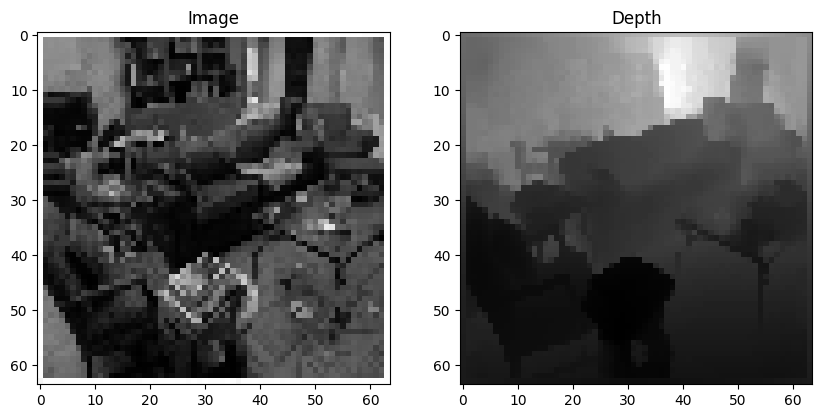

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[0][0].numpy())
axs[1].imshow(x_train[1][0].numpy())
axs[0].set_title('Image')
axs[1].set_title('Depth')

In [5]:
import os
converter = Converter(cfg)

os.makedirs(cfg.save_model_dir, exist_ok=True)
os.makedirs(cfg.save_cfiles_dir, exist_ok=True)
os.makedirs(cfg.save_test_data_dir, exist_ok=True)

In [6]:


model_names = [
    "depth_model_quant8_dynR",
    "depth_full_quant",
    "depth_qat_int8",
    "pruned_model",
    "pruned_model_unstructured",
    "pruned_model_unstructured_dynamic",
    "pruned_qat_model",
    "depth_model_fp32",
]
cfiles = {
    "depth_model_quant8_dynR": "depth_model_quant8_dynR",
    "depth_full_quant": "q8depth",
    "depth_qat_int8": "qat8depth",
    "pruned_model": "pruned",
    "pruned_model_unstructured": "pruned_unstructured",
    "pruned_model_unstructured_dynamic": "pruned_unstructured_dynamic",
    "pruned_qat_model": "pruned_unstructured_qat_model",
    "depth_model_fp32": "depth_model_fp32",
}
save_test_data(cfg.save_test_data_dir, x_train[0], x_train[1])

Test image data location:  /home/adam-torek/AIHardware_FinalProject/code/test_data/x_test_depth.npy
Test labels location:  /home/adam-torek/AIHardware_FinalProject/code/test_data/y_test_depth.npy


In [7]:
import pickle
from eval import eval_model
from loss import calculate_loss
from model import get_model
import tensorflow_model_optimization as tfmot


def fit_eval(model, model_name, do_save_model=True, epochs=cfg.epochs, do_savefig=True):
    metrics = keras.metrics.Mean(name="loss")

    def custom_metric(y_true, y_pred, sample_weight=None):
        metric_value = calculate_loss(y_true, y_pred)
        metrics.update_state(metric_value, sample_weight=sample_weight)
        return metric_value

    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss="mae", metrics=[custom_metric])

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.2, min_lr=1e-7, patience=5, min_delta=1e-2, verbose=1
    )
    callbacks = [reduce_lr]
    if "pruned" in model_name:
        callbacks.append(tfmot.sparsity.keras.UpdatePruningStep())
    if not cfg.do_overfit:
        tbCallBack = keras.callbacks.TensorBoard(
            log_dir=f"{cfg.logdir}/tb_logs",
            histogram_freq=0,
            write_graph=False,
            write_images=False,
        )
        es = keras.callbacks.EarlyStopping(
            patience=cfg.es_patience, 
            min_delta=5e-3, 
            monitor="loss",
        )
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=cfg.logdir + f"/{model_name}" + ".weights.h5",
            save_weights_only=True,
            monitor="custom_metric",
            mode="min",
        )
        callbacks.append(es)
        callbacks.append(model_checkpoint_callback)
        callbacks.append(tbCallBack)
    history = model.fit(
        x=ds_train,
        epochs=epochs,
        validation_data=ds_val,
        callbacks=callbacks,
        verbose=1,
    )
    with open(f"{cfg.save_model_dir}/{model_name}_history.pkl", "wb") as f:
        pickle.dump(history.history, f)

    pu.plot_history(history, f"{cfg.save_model_dir}/{model_name}_history.png")
    if not do_savefig:
        plt.show()
    tflite_path=None
    model_tflite=None
    if do_save_model:
        model.save(f"{cfg.save_model_dir}/{model_name}.h5")
        model_tflite, tflite_path = converter.keras_to_tflite(model, model_name, do_return_path=True)
    metrics = eval_model(
        model=model,
        test_ds=ds_val,
        tflite_path=tflite_path,
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
    return model_tflite, metrics, history

In [ ]:
# Build model
fp_model = get_model(
     cfg.img_size, in_channels=cfg.in_channels, use_qat=False,
)
fit_eval(fp_model, model_names[7], epochs=cfg.epochs)
model_tflite, tflite_path = converter.keras_to_tflite(fp_model, model_names[7], do_return_path=True)
write_model_h(cfiles[model_names[7]], model_tflite, cfg.save_cfiles_dir)

Epoch 1/10
    251/Unknown - 11s 26ms/step - loss: 0.1021 - custom_metric: 0.3098

1/1 [==============================] - 0s 402ms/step
MAE: 0.10, RMSE: 0.02, loss: 0.22


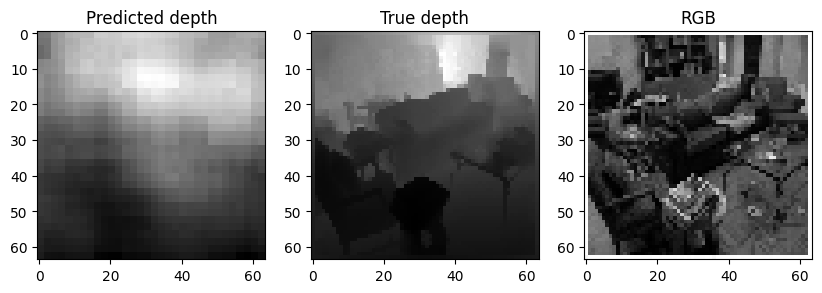

In [ ]:
out = fp_model.predict(x_train[0][0][None, ...])
plot_eval_results(out[0], x_train[1][0], x_train[0][0])

In [ ]:
dynR_quant_tflite_model = converter.dynamic_range_quantization(fp_model, model_names[0])

INFO:tensorflow:Assets written to: /tmp/tmpekd3civf/assets


INFO:tensorflow:Assets written to: /tmp/tmpekd3civf/assets


Model was saved at location: /home/adam-torek/AIHardware_FinalProject/code/models/depth_model_quant8_dynR.tflite


W0000 00:00:1731274216.174469  103410 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731274216.174487  103410 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-10 14:30:16.174626: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpekd3civf
2024-11-10 14:30:16.179642: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-10 14:30:16.179654: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpekd3civf
2024-11-10 14:30:16.211130: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-10 14:30:16.362724: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpekd3civf
2024-11-10 14:30:16.406333: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 231708 microseconds.


In [ ]:
tflite_model_quant_int8=converter.eight_bit_quantization(fp_model, ds_train, model_name=model_names[1])
converter.check_quantized_model(tflite_model_quant_int8)

INFO:tensorflow:Assets written to: /tmp/tmpr9h0je8j/assets


INFO:tensorflow:Assets written to: /tmp/tmpr9h0je8j/assets
/home/adam-torek/miniconda3/envs/ai_hardware/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1731274222.939009  103410 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731274222.939026  103410 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-10 14:30:22.939162: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpr9h0je8j
2024-11-10 14:30:22.948147: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-10 14:30:22.948161: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpr9h0je8j
2024-11-10 14:30:22.990502: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-10 14:30:23.162278: I tensorflow/cc/saved_model

Model was saved at location: /home/adam-torek/AIHardware_FinalProject/code/models/depth_full_quant.tflite
TFLite Model size with 8-bit quantization: 103 KB
TFLite Model size without quantization: 296 KB

Reduction in model size by a factor of 2.862223
input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


2024-11-10 14:30:29.083083: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [ ]:
depth_full_quant_tflite_path=f'{cfg.save_model_dir}/{model_names[1]}.tflite'
eval_model(
        ds_val,
        tflite_path=depth_full_quant_tflite_path,
        model=None,
        model_name=model_names[1],
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_names[1]], tflite_model_quant_int8, cfg.save_cfiles_dir)

Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
depth_full_quant model metrics:
mse: 5535.773
mae: 70.578
eval_loss: -1.000
eval_metric: -1.000
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json


Epoch 1/10


I0000 00:00:1731303361.720786  199903 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731303362.487471  199896 service.cc:148] XLA service 0x7dfd208a0020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731303362.487485  199896 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-10 22:36:02.491451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731303362.541390  199896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   6336/Unknown - 184s 28ms/step - loss: 0.0880 - custom_metric: 0.1995

2024-11-10 22:39:01.659427: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 22:39:01.659460: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[gradient_tape/mean_absolute_error/sub/Shape_1/_6]]
2024-11-10 22:39:08.979031: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_70]]


6336/6336 [==============================] - 192s 29ms/step - loss: 0.0880 - custom_metric: 0.1995 - val_loss: 10.4753 - val_custom_metric: 1.9001 - lr: 0.0010
Epoch 2/10
6336/6336 [==============================] - 183s 29ms/step - loss: 0.0903 - custom_metric: 0.1785 - val_loss: 10.4378 - val_custom_metric: 1.8961 - lr: 0.0010
Epoch 3/10
6336/6336 [==============================] - 184s 29ms/step - loss: 0.0915 - custom_metric: 0.1756 - val_loss: 10.4244 - val_custom_metric: 1.8945 - lr: 0.0010
Epoch 4/10
6336/6336 [==============================] - 183s 29ms/step - loss: 0.0919 - custom_metric: 0.1753 - val_loss: 10.4343 - val_custom_metric: 1.8964 - lr: 0.0010
Epoch 5/10
6336/6336 [==============================] - 184s 29ms/step - loss: 0.0920 - custom_metric: 0.1755 - val_loss: 10.4348 - val_custom_metric: 1.8955 - lr: 0.0010
Epoch 6/10
6335/6336 [============================>.] - ETA: 0s - loss: 0.0923 - custom_metric: 0.1771
Epoch 6: ReduceLROnPlateau reducing learning rate to 

/home/adam-torek/miniconda3/envs/ai_hardware/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
I0000 00:00:1731304838.125608  199741 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1731304838.125681  199741 single_machine.cc:361] Starting new session
I0000 00:00:1731304838.126622  199741 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21913 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6
W0000 00:00:1731304838.455530  199741 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731304838.455549  199741 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
INFO: Created 

Model was saved at location: /home/adam-torek/AIHardware_FinalProject/code/models/depth_qat_int8.tflite
HDF5 Model size: 1373 KB
TFLite Model size: 360 KB

Reduction in file size by a factor of 3.810630
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
depth_qat_int8 model metrics:
mse: 135.944
mae: 10.429
eval_loss: 10.429
eval_metric: 1.896
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json


I0000 00:00:1731304856.487587  199741 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1731304856.487674  199741 single_machine.cc:361] Starting new session
I0000 00:00:1731304856.488296  199741 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21913 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6
/home/adam-torek/miniconda3/envs/ai_hardware/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1731304856.808580  199741 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731304856.808594  199741 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


RuntimeError: tensorflow/lite/kernels/transpose_conv.cc:487 affine_quantization->scale->size != weights->dims->data[affine_quantization->quantized_dimension] (1 != 48)Node number 22 (TRANSPOSE_CONV) failed to prepare.

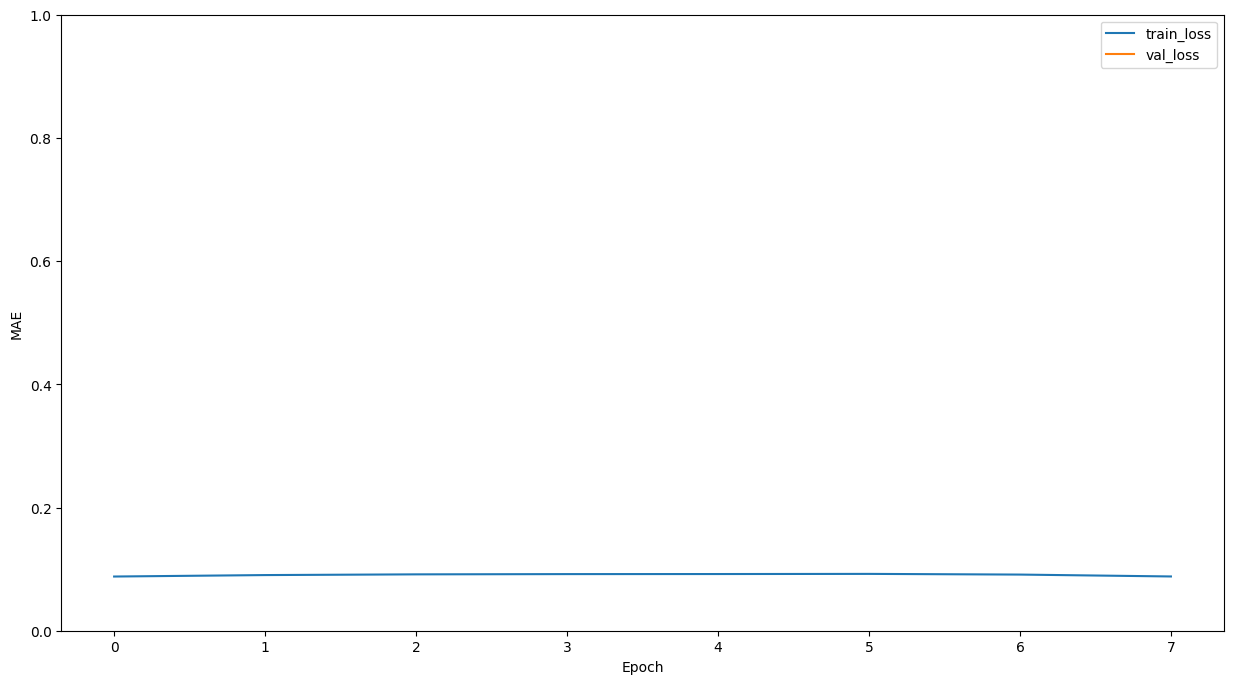

In [8]:
quant_aware_model = get_model(
    cfg.img_size, in_channels=cfg.in_channels, use_qat=True
)
model_name = model_names[2]
fit_eval(quant_aware_model, model_name)
quant_aware_model_converted = converter.eight_bit_quantization(
    quant_aware_model, ds_train, model_name=model_name
)
write_model_h(cfiles[model_name], quant_aware_model_converted, cfg.save_cfiles_dir)

I0000 00:00:1731279783.577091  161950 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731279784.335127  161958 service.cc:148] XLA service 0x7d203189bd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731279784.335142  161958 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-10 16:03:04.339267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731279784.388375  161958 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   6335/Unknown - 183s 27ms/step - loss: 0.0994 - custom_metric: 0.1932

2024-11-10 16:05:58.609985: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 16:05:58.610024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5295772366297170560
2024-11-10 16:05:58.610034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13564323822812373772
2024-11-10 16:05:58.610041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3017908566864332538
2024-11-10 16:05:58.610057: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 782891231021893540
2024-11-10 16:05:58.610064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8853451020840331740
2024-11-10 16:05:58.610072: I tensorflow/core/framework/local_rendezvou

6336/6336 [==============================] - 190s 28ms/step - loss: 0.0994 - custom_metric: 0.1932 - val_loss: 10.4299 - val_custom_metric: 1.8961 - lr: 0.0010
pruned_model model metrics:
eval_loss: 10.430
eval_metric: 1.896
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json
Saved pruned Keras model to: /home/adam-torek/AIHardware_FinalProject/code/models/pruned_model.h5


/home/adam-torek/AIHardware_FinalProject/TinyML_CNN/model.py:126: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


INFO:tensorflow:Assets written to: /tmp/tmpdepmugvc/assets


INFO:tensorflow:Assets written to: /tmp/tmpdepmugvc/assets
W0000 00:00:1731279975.561891  161795 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731279975.561903  161795 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-10 16:06:15.562107: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdepmugvc
2024-11-10 16:06:15.567483: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-10 16:06:15.567494: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdepmugvc
I0000 00:00:1731279975.591422  161795 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-10 16:06:15.593976: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-10 16:06:15.659733: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdepmugvc
2024-11-10 16:06:15.684

Model was saved at location: /home/adam-torek/AIHardware_FinalProject/code/models/pruned_model.tflite
HDF5 Model size: 436 KB
TFLite Model size: 296 KB

Reduction in file size by a factor of 1.473189


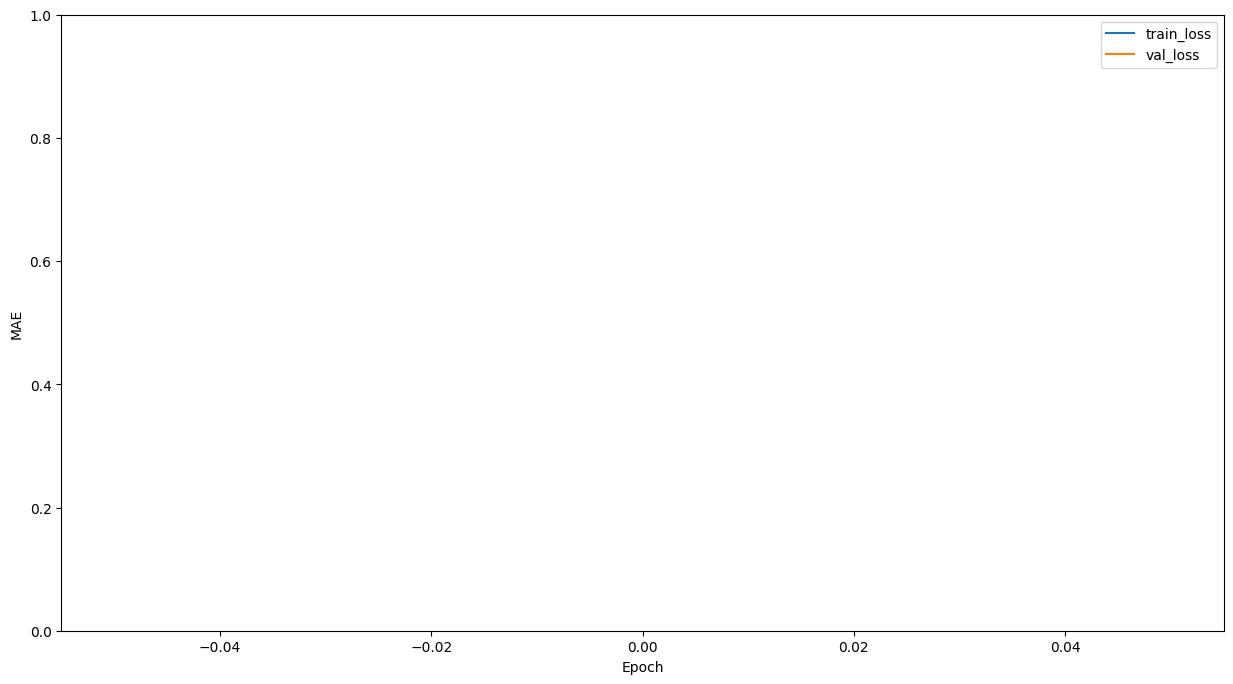

In [9]:
model_name = model_names[3]
pruned_model = get_model(cfg.img_size, in_channels=cfg.in_channels, use_qat=False, use_pruning=True,
                         use_pruning_struct=True)
fit_eval(pruned_model, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(pruned_model, f"{cfg.save_model_dir}/{model_name}.h5")
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

   6336/Unknown - 180s 27ms/step - loss: 0.0928 - custom_metric: 0.1890

2024-11-10 16:33:06.790916: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 16:33:06.790978: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14023776455527809114
2024-11-10 16:33:06.790991: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8089735494199410994
2024-11-10 16:33:06.791006: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8946543905771266564
2024-11-10 16:33:06.791023: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14591233137973265250
2024-11-10 16:33:06.791038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17398687048518485308
2024-11-10 16:33:06.791054: I tensorflow/core/framework/local_rendez

6336/6336 [==============================] - 187s 28ms/step - loss: 0.0928 - custom_metric: 0.1890 - val_loss: 10.4191 - val_custom_metric: 1.8956 - lr: 0.0010
pruned_model_unstructured model metrics:
eval_loss: 10.420
eval_metric: 1.896
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json


/home/adam-torek/AIHardware_FinalProject/TinyML_CNN/model.py:126: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


Saved pruned Keras model to: /home/adam-torek/AIHardware_FinalProject/code/models/pruned_model_unstructured.h5
INFO:tensorflow:Assets written to: /tmp/tmpmo06le42/assets


INFO:tensorflow:Assets written to: /tmp/tmpmo06le42/assets
W0000 00:00:1731281603.272508  161795 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731281603.272522  161795 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-10 16:33:23.272663: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmo06le42
2024-11-10 16:33:23.278163: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-10 16:33:23.278175: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpmo06le42
2024-11-10 16:33:23.304349: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-10 16:33:23.372643: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpmo06le42
2024-11-10 16:33:23.398276: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 125616

Model was saved at location: /home/adam-torek/AIHardware_FinalProject/code/models/pruned_model_unstructured.tflite
HDF5 Model size: 436 KB
TFLite Model size: 296 KB

Reduction in file size by a factor of 1.473226
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
pruned_model_unstructured model metrics:
mse: 135.646
mae: 10.419
eval_loss: 10.419
eval_metric: 1.896
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json


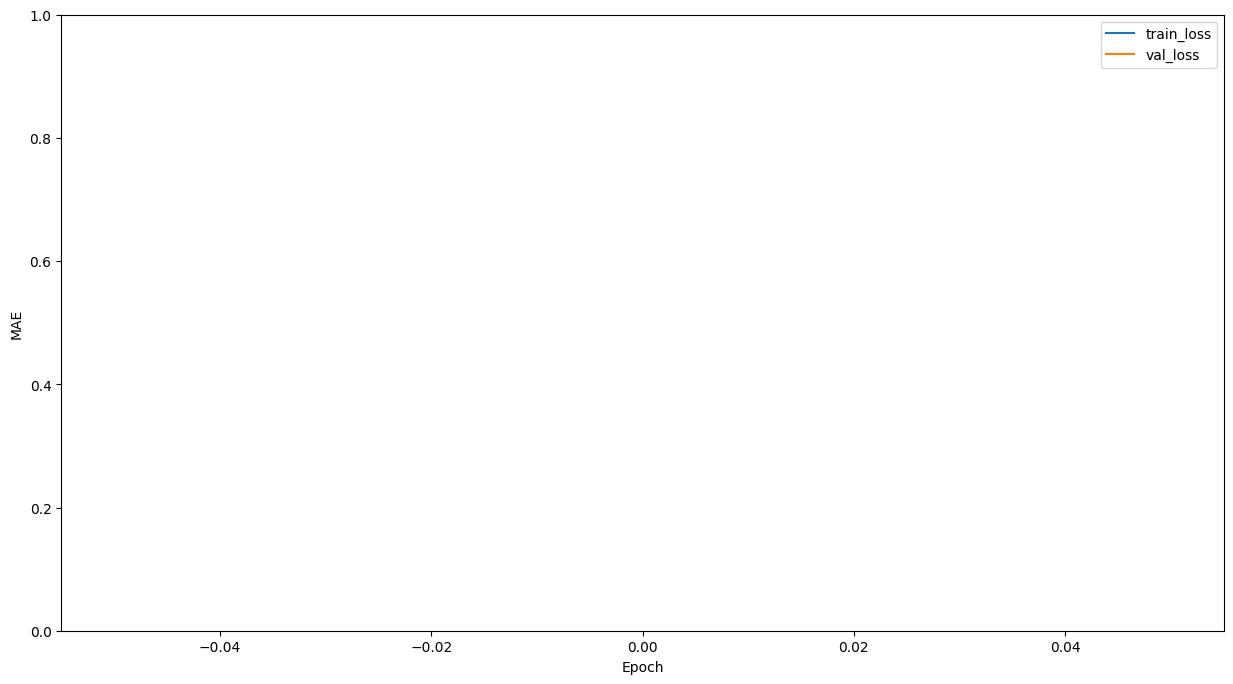

In [19]:
model_name = model_names[4]
pruned_model_unstruct = get_model(
    cfg.img_size,
    in_channels=cfg.in_channels,
    use_qat=False,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=False,
)
fit_eval(pruned_model_unstruct, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(
    pruned_model_unstruct, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
eval_model(
        model=pruned_model_unstruct,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

   6336/Unknown - 178s 27ms/step - loss: 0.1008 - custom_metric: 0.2049

2024-11-10 16:13:51.814522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 341958215582629920
2024-11-10 16:13:51.814561: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[model_1/prune_low_magnitude_separable_conv2d_4/assert_greater_equal/Assert/AssertGuard/else/_77/model_1/prune_low_magnitude_separable_conv2d_4/assert_greater_equal/Assert/AssertGuard/Assert/data_0/_194]]
2024-11-10 16:13:51.814605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14127403126716538972
2024-11-10 16:13:51.814621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9075303719339753837
2024-11-10 16:13:51.814636: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12300481991514703021
2024-11-10 

6336/6336 [==============================] - 186s 28ms/step - loss: 0.1008 - custom_metric: 0.2049 - val_loss: 10.5174 - val_custom_metric: 1.9188 - lr: 0.0010
pruned_model_unstructured_dynamic model metrics:
eval_loss: 10.518
eval_metric: 1.919
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json


/home/adam-torek/AIHardware_FinalProject/TinyML_CNN/model.py:126: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


Saved pruned Keras model to: /home/adam-torek/AIHardware_FinalProject/code/models/pruned_model_unstructured_dynamic.h5
INFO:tensorflow:Assets written to: /tmp/tmp6jdnevvg/assets


INFO:tensorflow:Assets written to: /tmp/tmp6jdnevvg/assets
W0000 00:00:1731280449.165342  161795 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731280449.165356  161795 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-10 16:14:09.165503: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6jdnevvg
2024-11-10 16:14:09.171043: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-10 16:14:09.171058: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp6jdnevvg
2024-11-10 16:14:09.197168: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-10 16:14:09.265554: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp6jdnevvg
2024-11-10 16:14:09.291159: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 125659

Model was saved at location: /home/adam-torek/AIHardware_FinalProject/code/models/pruned_model_unstructured_dynamic.tflite
HDF5 Model size: 436 KB
TFLite Model size: 296 KB

Reduction in file size by a factor of 1.472821
Evaluated on 100 images.
Evaluated on 200 images.
Evaluated on 300 images.
Evaluated on 400 images.
Evaluated on 500 images.
Evaluated on 600 images.
pruned_model_unstructured_dynamic model metrics:
mse: 138.049
mae: 10.518
eval_loss: 10.517
eval_metric: 1.919
Saved metrics to /home/adam-torek/AIHardware_FinalProject/code/models/metrics.json


2024-11-10 16:14:22.284950: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3296398734198652123


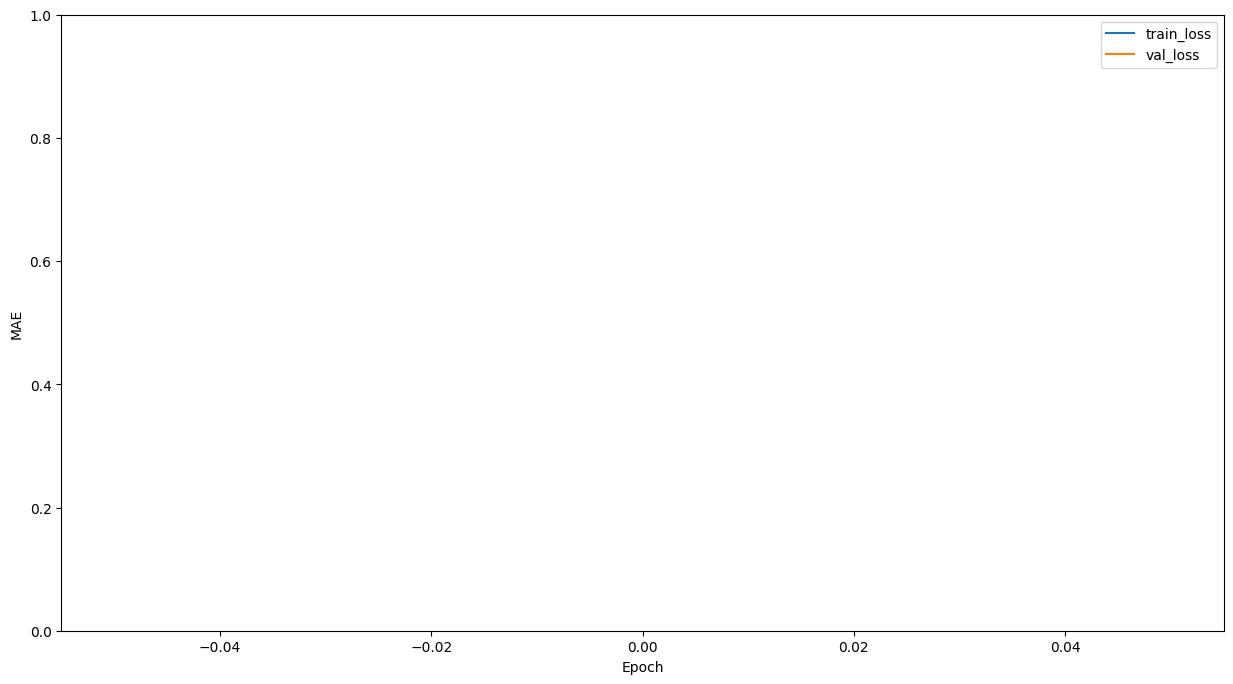

In [14]:
model_name = model_names[5]
pruned_model_unstruct_dynamic = get_model(
    cfg.img_size,
    in_channels=cfg.in_channels,
    use_qat=False,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=True,
)
fit_eval(pruned_model_unstruct_dynamic, model_name, do_save_model=False)
pruned_model_unstructured_for_export = save_pruned_model(
    pruned_model_unstruct_dynamic, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_unstructured_for_export, model_name)
eval_model(
        model=pruned_model_unstruct_dynamic,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

In [16]:
model_name = model_names[6]
pruned_qat_model = get_model(
    cfg.img_size,
    in_channels=cfg.in_channels,
    use_qat=True,
    use_pruning=True,
    use_pruning_struct=False,
    use_dynamic_sparsity=False,
    pruned_model_unstructured_for_export=pruned_model_unstructured_for_export
)
fit_eval(pruned_qat_model, model_name, do_save_model=False)
pruned_model_for_export = save_pruned_model(
    pruned_qat_model, f"{cfg.save_model_dir}/{model_name}.h5"
)
pruned_tflite_model = converter.keras_to_tflite(pruned_model_for_export, model_name)
eval_model(
        model=pruned_qat_model,
        test_ds=ds_val,
        tflite_path=f"{cfg.save_model_dir}/{model_name}.tflite",
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_name], pruned_tflite_model, cfg.save_cfiles_dir)

RuntimeError: Layer conv2d_transpose_6:<class 'tf_keras.src.layers.convolutional.conv2d_transpose.Conv2DTranspose'> is not supported. You can quantize this layer by passing a `tfmot.quantization.keras.QuantizeConfig` instance to the `quantize_annotate_layer` API.